In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import neurokit2 as nk

In [3]:
# load bbi data
bbi_df = pd.read_csv('~/OneDrive - BGU/STAR_Center/DataCollection/Pilot_Project-26092024/PID11199_f8a225cf/garmin-device-bbi/240904_garmin-device-bbi_PID11199_f8a225cf.csv',
                     skiprows=5)

In [4]:
bbi_df.head()

,timezone,unixTimestampInMs,isoDate,deviceType,bbi,confidence
0,Asia/Jerusalem,1725483239000,2024-09-04T23:53:59.000+03:00,garmin_Vivosmart5,633,NaN
1,Asia/Jerusalem,1725483239701,2024-09-04T23:53:59.701+03:00,garmin_Vivosmart5,701,NaN
2,Asia/Jerusalem,1725483240512,2024-09-04T23:54:00.512+03:00,garmin_Vivosmart5,811,NaN
3,Asia/Jerusalem,1725483241322,2024-09-04T23:54:01.322+03:00,garmin_Vivosmart5,810,NaN
4,Asia/Jerusalem,1725483242122,2024-09-04T23:54:02.122+03:00,garmin_Vivosmart5,800,NaN


In [5]:
peaks = nk.intervals_to_peaks(bbi_df['bbi'])


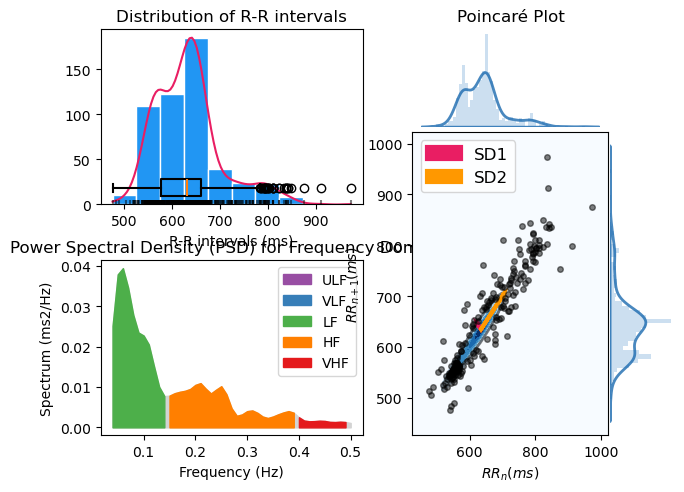

In [9]:
hrv = nk.hrv(peaks, show=True)

In [10]:
hrv

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,634.891221,71.204668,64.495746,36.448618,31.157471,57.187331,NaN,NaN,23.889804,23.912541,...,0.444904,7.361104,0.464715,1.014892,0.98461,1.137998,1.083776,1.634882,1.957777,0.430984


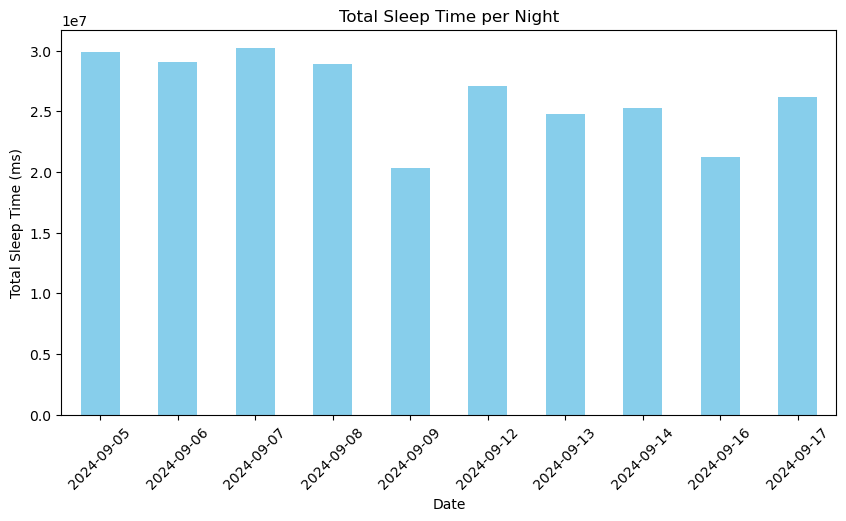

In [13]:
# Load the Garmin sleep data file
file_path = '~/OneDrive - BGU/STAR_Center/DataCollection/Pilot_Project-26092024/PID11199_f8a225cf/garmin-connect-sleep-stage/240905_garmin-connect-sleep-stage_PID11199_f8a225cf.csv'

# Skip initial metadata rows and load the actual data
data = pd.read_csv(file_path, skiprows=4)

# Set the first row as header and drop it from the data
data.columns = data.iloc[0]
data = data[1:]

# Convert 'unixTimestampInMs' to a datetime object
data['DateTime'] =  pd.to_datetime(data['isoDate'])

# Convert 'durationInMs' to a numeric type for calculations
data['durationInMs'] = pd.to_numeric(data['durationInMs'], errors='coerce')

# Extract the date from the 'DateTime' column to group by each night
data['Date'] = data['DateTime'].dt.date

# Calculate Total Sleep Time (TST) for each night in milliseconds
total_sleep_time = data.groupby('Date')['durationInMs'].sum()

# Plot Total Sleep Time (TST) for each night
plt.figure(figsize=(10, 5))
total_sleep_time.plot(kind='bar', color='skyblue')
plt.title('Total Sleep Time per Night')
plt.xlabel('Date')
plt.ylabel('Total Sleep Time (ms)')
plt.xticks(rotation=45)
plt.show()


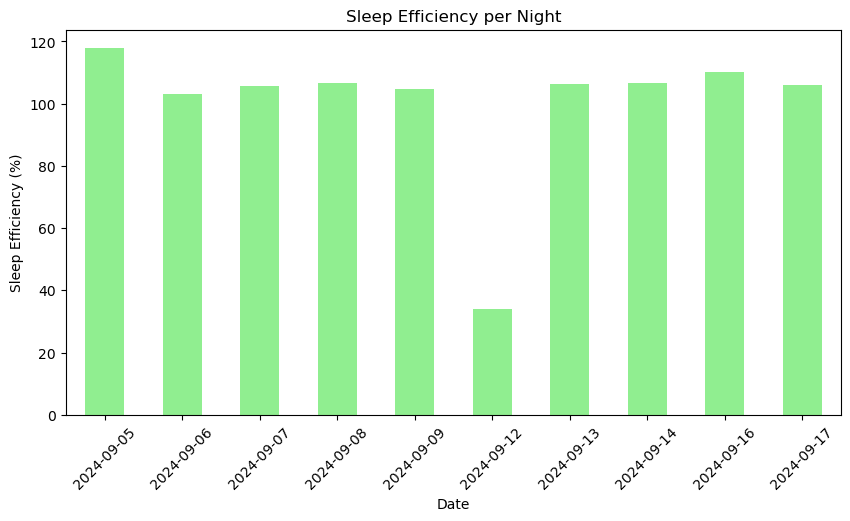

In [14]:

# Sleep Efficiency can be calculated as (Total Sleep Time / Time in Bed) * 100
# Assuming the first and last timestamp in each night as bed start and bed end

# First, let's get the time in bed for each night
time_in_bed = data.groupby('Date')['DateTime'].agg(['min', 'max'])
time_in_bed['timeInBedMs'] = (time_in_bed['max'] - time_in_bed['min']).dt.total_seconds() * 1000  # Convert to ms

# Calculate Sleep Efficiency as percentage
sleep_efficiency = (total_sleep_time / time_in_bed['timeInBedMs']) * 100

# Plot Sleep Efficiency for each night
plt.figure(figsize=(10, 5))
sleep_efficiency.plot(kind='bar', color='lightgreen')
plt.title('Sleep Efficiency per Night')
plt.xlabel('Date')
plt.ylabel('Sleep Efficiency (%)')
plt.xticks(rotation=45)
plt.show()


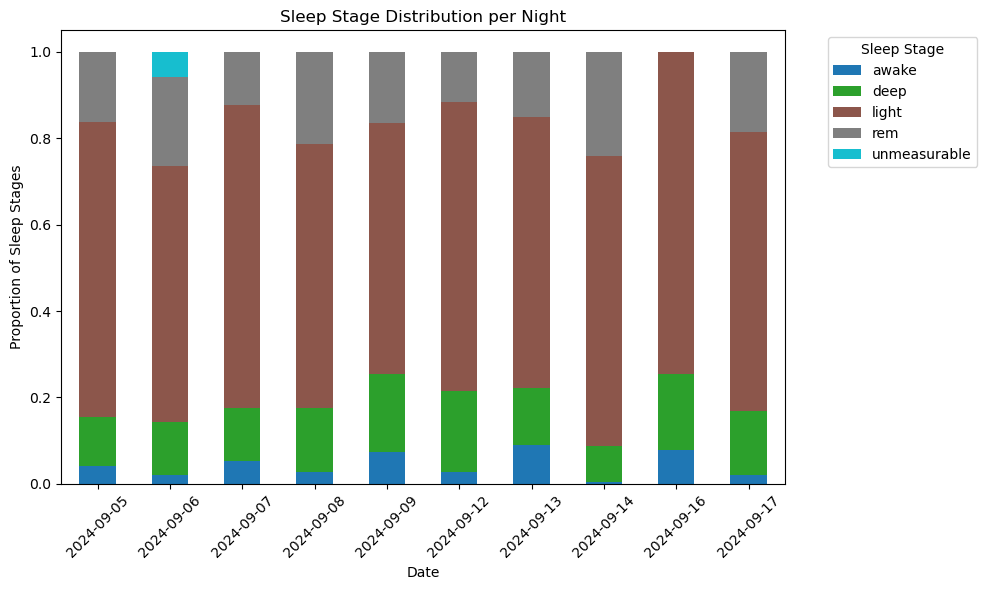

In [21]:
# Calculate the proportion of each sleep stage for each night
sleep_stage_distribution = data.groupby(['Date', 'type'])['durationInMs'].sum().unstack()

# Normalize the sleep stage proportions
sleep_stage_distribution = sleep_stage_distribution.div(sleep_stage_distribution.sum(axis=1), axis=0)

# Plot Sleep Stages Distribution for each night
sleep_stage_distribution.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab10')
plt.title('Sleep Stage Distribution per Night')
plt.xlabel('Date')
plt.ylabel('Proportion of Sleep Stages')
plt.xticks(rotation=45)
plt.legend(title='Sleep Stage')
# Move the legend to the right of the plot
plt.legend(title='Sleep Stage', bbox_to_anchor=(1.05, 1), loc='upper left')

# Optimize layout to accommodate the outside legend
plt.tight_layout()
plt.show()


Date
2024-09-05    100.00000
2024-09-06    100.00000
2024-09-07    100.00000
2024-09-08    100.00000
2024-09-09    100.00000
2024-09-12     33.08214
2024-09-13    100.00000
2024-09-14    100.00000
2024-09-16    100.00000
2024-09-17    100.00000
dtype: float64


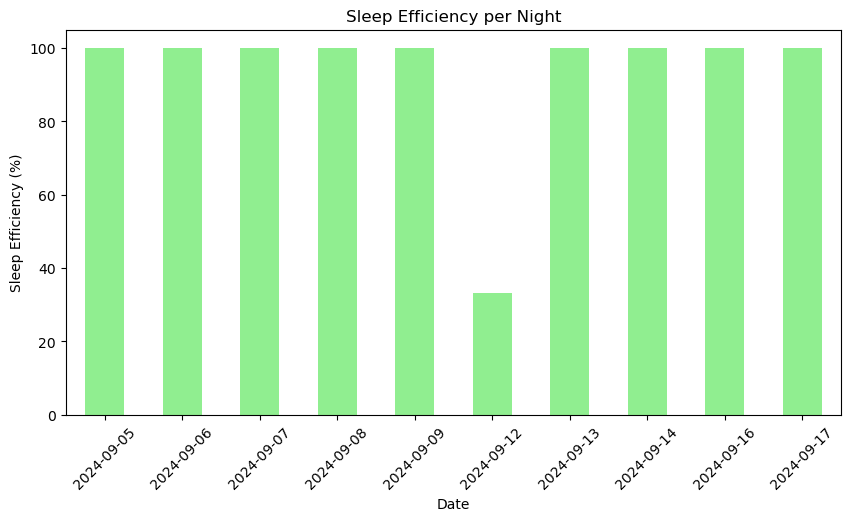

In [17]:
# Convert 'isoDate' to a datetime object, and parse duration into numeric
data['DateTime'] = pd.to_datetime(data['isoDate'])
data['durationInMs'] = pd.to_numeric(data['durationInMs'], errors='coerce')

# Sort data by 'DateTime' to check for overlaps
data = data.sort_values(by='DateTime')

# Assuming the participant lays down at the first recorded time and gets up at the last time each night
data['Date'] = data['DateTime'].dt.date
time_in_bed = data.groupby('Date')['DateTime'].agg(['min', 'max'])
time_in_bed['TimeInBedMs'] = (time_in_bed['max'] - time_in_bed['min']).dt.total_seconds() * 1000

# Calculate total sleep time without overlaps
data['EndTime'] = data['DateTime'] + pd.to_timedelta(data['durationInMs'], unit='ms')
data['CorrectedDurationMs'] = data.apply(lambda row: (min(row['EndTime'], time_in_bed.loc[row['Date'], 'max']) - row['DateTime']).total_seconds() * 1000, axis=1)
total_sleep_time = data.groupby('Date')['CorrectedDurationMs'].sum()

# Calculate sleep efficiency
sleep_efficiency = (total_sleep_time / time_in_bed['TimeInBedMs']) * 100

# Check values
print(sleep_efficiency)

# Plot Sleep Efficiency for each night
plt.figure(figsize=(10, 5))
sleep_efficiency.plot(kind='bar', color='lightgreen')
plt.title('Sleep Efficiency per Night')
plt.xlabel('Date')
plt.ylabel('Sleep Efficiency (%)')
plt.xticks(rotation=45)
plt.show()
